<h1>Demand forecasting with BigQuery and TensorFlow</h1>

In this notebook, we will develop a machine learning model to predict the demand for taxi cabs in New York.

To develop the model, we will need to get historical data of taxicab usage. This data exists in BigQuery. Let's start by looking at the schema.

In [1]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [2]:
%bq tables describe --name bigquery-public-data.new_york.tlc_yellow_trips_2015

<h2> Analyzing taxicab demand </h2>

Let's pull the number of trips for each day in the 2015 dataset using Standard SQL.

In [4]:
%bq query
SELECT 
  EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` 
LIMIT 10

daynumber
301
178
308
336
150
74
15
229
214
237


<h3> Modular queries and Pandas dataframe </h3>

Let's use the total number of trips as our proxy for taxicab demand (other reasonable alternatives are total trip_distance or total fare_amount).  It is possible to predict multiple variables using Tensorflow, but for simplicity, we will stick to just predicting the number of trips.

We will give our query a name 'taxiquery' and have it use an input variable '$YEAR'. We can then invoke the 'taxiquery' by giving it a YEAR.  The to_dataframe() converts the BigQuery result into a <a href='http://pandas.pydata.org/'>Pandas</a> dataframe.

In [5]:
%bq query -n taxiquery
WITH trips AS (
  SELECT EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber 
  FROM `bigquery-public-data.new_york.tlc_yellow_trips_*`
  where _TABLE_SUFFIX = @YEAR
)
SELECT daynumber, COUNT(1) AS numtrips FROM trips
GROUP BY daynumber ORDER BY daynumber

In [6]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
trips[:5]

,daynumber,numtrips
0,1,382014
1,2,345296
2,3,406769
3,4,328848
4,5,363454


<h3> Benchmark </h3>

Often, a reasonable estimate of something is its historical average. We can therefore benchmark our machine learning model against the historical average.

In [7]:
avg = np.mean(trips['numtrips'])
print 'Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((trips['numtrips'] - avg)**2)))

Just using average=400309.558904 has RMSE of 51613.6516905


The mean here is about 400,000 and the root-mean-square-error (RMSE) in this case is about 52,000. In other words, if we were to estimate that there are 400,000 taxi trips on any given day, that estimate is will be off on average by about 52,000 in either direction.
  
Let's see if we can do better than this -- our goal is to make predictions of taxicab demand whose RMSE is lower than 52,000.

What kinds of things affect people's use of taxicabs?

<h2> Weather data </h2>

We suspect that weather influences how often people use a taxi. Perhaps someone who'd normally walk to work would take a taxi if it is very cold or rainy.

One of the advantages of using a global data warehouse like BigQuery is that you get to mash up unrelated datasets quite easily.

In [8]:
%bq query
SELECT * FROM `bigquery-public-data.noaa_gsod.stations`
WHERE state = 'NY' AND wban != '99999' AND name LIKE '%LA GUARDIA%'

usaf,wban,name,country,state,call,lat,lon,elev,begin,end
725030,14732,LA GUARDIA AIRPORT,US,NY,KLGA,40.779,-73.88,+0003.4,19730101,20180507


<h3> Variables </h3>

Let's pull out the minimum and maximum daily temperature (in Fahrenheit) as well as the amount of rain (in inches) for La Guardia airport.

In [10]:
%bq query -n wxquery
SELECT EXTRACT (DAYOFYEAR FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber,
       MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE stn='725030' AND _TABLE_SUFFIX = @YEAR
GROUP BY 1 ORDER BY daynumber DESC

In [11]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
weather = wxquery.execute(query_params=query_parameters).result().to_dataframe()
weather[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,365,5,46.0,48.2,0.17
1,364,4,34.0,48.0,0.13
2,363,3,33.8,46.9,0.37
3,362,2,39.0,62.1,0.02
4,361,1,46.0,62.6,0.14


<h3> Merge datasets </h3>

Let's use Pandas to merge (combine) the taxi cab and weather datasets day-by-day.

In [12]:
data = pd.merge(weather, trips, on='daynumber')
data[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,365,5,46.0,48.2,0.17,339939
1,364,4,34.0,48.0,0.13,319649
2,363,3,33.8,46.9,0.37,311730
3,362,2,39.0,62.1,0.02,301398
4,361,1,46.0,62.6,0.14,268841


<h3> Exploratory analysis </h3>

Is there a relationship between maximum temperature and the number of trips?

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


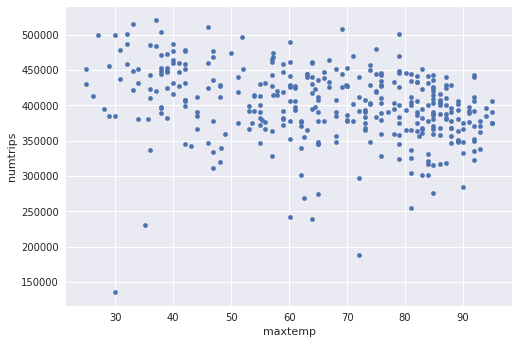

In [13]:
j = data.plot(kind='scatter', x='maxtemp', y='numtrips')

The scatterplot above doesn't look very promising. There appears to be a weak downward trend, but it's also quite noisy.

Is there a relationship between the day of the week and the number of trips?

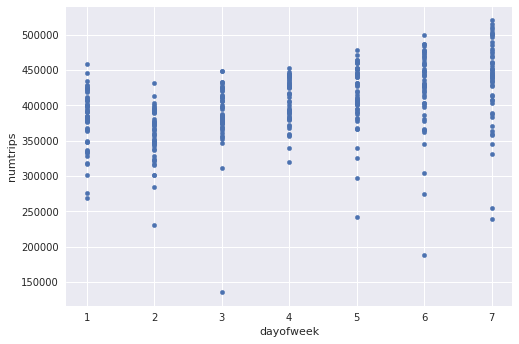

In [14]:
j = data.plot(kind='scatter', x='dayofweek', y='numtrips')

Hurrah, we seem to have found a predictor. It appears that people use taxis more later in the week. Perhaps New Yorkers make weekly resolutions to walk more and then lose their determination later in the week, or maybe it reflects tourism dynamics in New York City.

Perhaps if we took out the <em>confounding</em> effect of the day of the week, maximum temperature will start to have an effect. Let's see if that's the case:

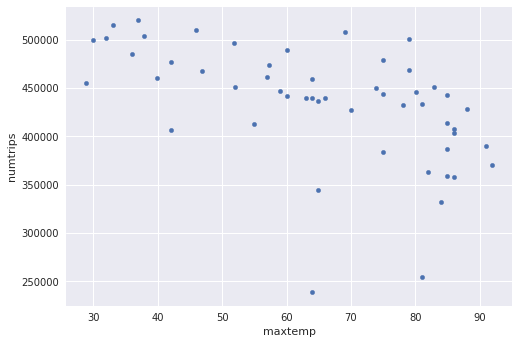

In [16]:
j = data[data['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

Removing the confounding factor does seem to reflect an underlying trend around temperature. But ... the data are a little sparse, don't you think?  This is something that you have to keep in mind -- the more predictors you start to consider (here we are using two: day of week and maximum temperature), the more rows you will need so as to avoid <em> overfitting </em> the model.

<h3> Adding 2014 and 2016 data </h3>

Let's add in 2014 and 2016 data to the Pandas dataframe.  Note how useful it was for us to modularize our queries around the YEAR.

In [17]:
data2 = data # 2015 data
for year in [2014, 2016]:
    query_parameters = [
      {
        'name': 'YEAR',
        'parameterType': {'type': 'STRING'},
        'parameterValue': {'value': year}
      }
    ]
    weather = wxquery.execute(query_params=query_parameters).result().to_dataframe()
    trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
    data_for_year = pd.merge(weather, trips, on='daynumber')
    data2 = pd.concat([data2, data_for_year])
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,183.166971,4.005474,48.195073,66.151825,0.117272,403642.694343
std,105.510927,2.000449,18.031228,18.484065,0.320836,63767.524397
min,1.000000,1.000000,1.000000,21.000000,0.000000,78133.000000
25%,92.000000,2.000000,35.100000,51.950000,0.000000,363809.000000
50%,183.000000,4.000000,48.900000,68.000000,0.000000,402184.500000
75%,274.250000,6.000000,64.400000,82.900000,0.050000,447099.000000
max,366.000000,7.000000,82.000000,99.000000,4.880000,574530.000000


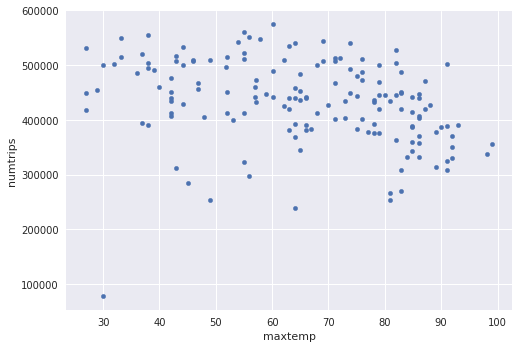

In [18]:
j = data2[data2['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

The data do seem a bit more robust.  If we had even more data, it would be better of course. But in this case, we only have 2014-2016 data for taxi trips, so that's what we will go with.

<h2> Machine Learning with Tensorflow </h2>

We'll use 80% of our dataset for training and 20% of the data for testing the model we have trained. Let's shuffle the rows of the Pandas dataframe so that this division is random.  The predictor (or input) columns will be every column in the database other than the number-of-trips (which is our target, or what we want to predict).

The machine learning models that we will use -- linear regression and neural networks -- both require that the input variables are numeric in nature.

The day of the week, however, is a categorical variable (i.e. Tuesday is not really greater than Monday). So, we should create separate columns for whether it is a Monday (with values 0 or 1), Tuesday, etc.

Against that, we do have limited data (remember: the more columns you use as input features, the more rows you need to have in your training dataset), and it appears that there is a clear linear trend by day of the week. So, we will opt for simplicity here and use the data as-is.  Try uncommenting the code that creates separate columns for the days of the week and re-run the notebook if you are curious about the impact of this simplification.

In [39]:
import tensorflow as tf
shuffled = data2.sample(frac=1, random_state=13)
# It would be a good idea, if we had more data, to treat the days as categorical variables
# with the small amount of data, we have though, the model tends to overfit
#predictors = shuffled.iloc[:,2:5]
#for day in xrange(1,8):
#  matching = shuffled['dayofweek'] == day
#  key = 'day_' + str(day)
#  predictors[key] = pd.Series(matching, index=predictors.index, dtype=float)
predictors = shuffled.iloc[:,1:5]
predictors[:5]

,dayofweek,mintemp,maxtemp,rain
9,2,32.0,43.0,0.00
279,6,37.9,57.0,0.52
163,5,71.1,91.0,0.00
225,6,55.9,78.1,0.00
218,6,55.0,91.9,0.00


In [40]:
shuffled[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
9,356,2,32.0,43.0,0.00,382112
279,86,6,37.9,57.0,0.52,465493
163,203,5,71.1,91.0,0.00,363728
225,141,6,55.9,78.1,0.00,414711
218,148,6,55.0,91.9,0.00,364951


In [41]:
targets = shuffled.iloc[:,5]
targets[:5]

9      382112
279    465493
163    363728
225    414711
218    364951
Name: numtrips, dtype: int64

Let's update our benchmark based on the 80-20 split and the larger dataset.

In [42]:
trainsize = int(len(shuffled['numtrips']) * 0.8)
avg = np.mean(shuffled['numtrips'][:trainsize])
rmse = np.sqrt(np.mean((targets[trainsize:] - avg)**2))
print 'Just using average={0} has RMSE of {1}'.format(avg, rmse)

Just using average=402667.682648 has RMSE of 62394.1123208


<h2> Linear regression with tf.contrib.learn </h2>

We scale the number of taxicab rides by 400,000 so that the model can keep its predicted values in the [0-1] range. The optimization goes a lot faster when the weights are small numbers.  We save the weights into ./trained_model_linear and display the root mean square error on the test dataset.

In [59]:
SCALE_NUM_TRIPS = 600000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model_linear', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean(np.power((targets[trainsize:].values - pred), 2)))
print 'LinearRegression has RMSE of {0}'.format(rmse)


starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
LinearRegression has RMSE of 56643.9526909


The RMSE here (57K) is lower than the benchmark (62K) indicates that we are doing about 10% better with the machine learning model than we would be if we were to just use the historical average (our benchmark).

<h2> Neural network with tf.contrib.learn </h2>

Let's make a more complex model with a few hidden nodes.

In [61]:
SCALE_NUM_TRIPS = 600000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.DNNRegressor(model_dir='./trained_model',
                                          hidden_units=[5, 5],                             
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean((targets[trainsize:].values - pred)**2))
print 'Neural Network Regression has RMSE of {0}'.format(rmse)

starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Neural Network Regression has RMSE of 56514.4991082


Using a neural network results in similar performance to the linear model when I ran it -- it might be because there isn't enough data for the NN to do much better. (NN training is a non-convex optimization, and you will get different results each time you run the above code).

<h2> Running a trained model </h2>

So, we have trained a model, and saved it to a file. Let's use this model to predict taxicab demand given the expected weather for three days.

Here we make a Dataframe out of those inputs, load up the saved model (note that we have to know the model equation -- it's not saved in the model file) and use it to predict the taxicab demand.

In [67]:
input = pd.DataFrame.from_dict(data = 
                               {'dayofweek' : [4, 5, 6],
                                'mintemp' : [60, 40, 50],
                                'maxtemp' : [70, 90, 60],
                                'rain' : [0, 0.5, 0]})
# read trained model from ./trained_model
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))

pred = np.multiply(list(estimator.predict(input.values)), SCALE_NUM_TRIPS )
print pred

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
[ 354762.8125   306764.6875   387226.65625]


Looks like we should tell some of our taxi drivers to take the day off on Thursday (day=5). No wonder -- the forecast calls for extreme weather fluctuations on Thursday.

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License